# Software Defect Detection

> Lazaros Panitsidis & Konstantinos Kravaritis<br />
> International Hellenic University <br />
> MSc Data Science <br />
> Machine Learning Concepts and Principles <br />
> lpanitsidis@ihu.edu.gr & kkravaritis@ihu.edu.gr

## Contents
1. [Useful Python Libraries](#0)
1. [Data Content](#1)
1. [Feature Engineering](#2)
     1. [Data Preprocessing](#3)
     1. [Visualization & Analysis](#4)
1. [Feature Selection and Random Forest Classification](#5)
     1. [Feature Selection by Correlation](#6)
     1. [Univariate feature selection (SelectKbest)](#7)
     1. [Recursive Feature Elimination (RFE)](#8)
     1. [Recursive Feature Elimination with Cross-Validation (RFECV)](#9)
     1. [Feature importances with a forest of trees](#10)
     1. [XGBoost Feature Importances](#11)
     1. [Minimum Redundancy & Maximum Relevance](#12)
1. [Feature extraction with PCA](#11)
1. [Summary](#12)

<a id='0'></a>
## Python Libraries

In [44]:
## Install Python libraries
# %pip install -U numpy
# %pip install -U pandas
# %pip install -U seaborn
# %pip install -U matplotlib
# %pip install -U scikit-learn
# %pip install -U imbalanced-learn

In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import statistics as stats # https://docs.python.org/3/library/statistics.html#statistics.fmean
#import scipy.stats as spstats
import matplotlib.pyplot as plt

### Validation & Normalization methods ###
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

### ML models ###
from sklearn.linear_model import LogisticRegression, SGDClassifier # C1 loss: log_loss => LogisticRegression with SGD
from sklearn.linear_model import Perceptron # C2
from sklearn.svm import SVC # C3
from sklearn.svm import LinearSVC # C4
from sklearn.tree import DecisionTreeClassifier # C5
from sklearn.ensemble import RandomForestClassifier # C6
from sklearn.neural_network import MLPClassifier # C7

### Metrics ###
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from imblearn.metrics import geometric_mean_score # https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.geometric_mean_score.html
import time
import timeit # https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit

### Pipeline ###
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

### Custom Modules ###
# from functions.data_types import optimize_dtypes
# from functions.dataframe_actions import df_info, df_clean
# from functions.ml_training import train_classifiers, train_classifiers_tuned

### Other configurations ###
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
# #import warnings library
# import warnings
# # ignore all warnings
# warnings.filterwarnings('ignore')

## Functions

#### Information about the dataframes

In [46]:
def df_info(dataframes, dataframe_names):
    """
    Finds useful information about all dataframes given in the function.

    Usage: pass a list of dataframes and their names into the function
    dataframes = [df1, df2, ...]
    dataframe_names = ["df1", "df2", ...]

    Output: print's information about schema, missing values, duplicate values and value counts for target column.
    """

    for df, df_name in zip(dataframes, dataframe_names):
        # Check if the dataframe has at least one column
        if not df.empty:
            print("----- information for ", df_name, " -----")
            print(df_name, " : ", df.shape, "(rows, columns)")
            print(df_name, " : ", df.isna().sum().sum(), "missing values")
            print(df_name, " : ", df.duplicated().sum(), "duplicate values")

            # Identify and count values of the last column
            last_column = df.columns[-1]
            value_counts = df[last_column].value_counts()

            print(df_name, " : Value counts for ", last_column)
            print(value_counts)
        else:
            print(df_name, ': The dataframe is empty.')

#### Clean dataframe from non-numeric values

In [47]:
def df_clean(df):
    """
    Eliminate invalid data from the dataframe.

    This function replaces non-numeric values in the specified columns
    with NaN and removes rows containing NaN values.

    Parameters:
    - df: pandas DataFrame

    Returns:
    - Cleaned DataFrame
    """
    df_columns = df.columns.to_list()

    # https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas
    
    num_df = (
        df.drop(df_columns, axis=1)
          .join(df[df_columns].apply(pd.to_numeric, errors='coerce'))
    )

    num_df = num_df[num_df[df_columns].notnull().all(axis=1)]

    return num_df

#### Optimize data types for more efficient computation

In [48]:
def optimize_dtypes(df):
  """
  Finds the optimal data type for each variable in a DataFrame.
  
  The 'np.iinfo(), np.finfo()' functions are used to obtain the minimum and maximum values 
  for the data types accurately, ensuring better compatibility across different systems.

  Args:
    df: A pandas DataFrame.

  Returns:
    A DataFrame containing the optimal data type for each variable.
  """

  data_types_dict = {}
  for column in df.columns:
    # Get the data type of the column.
    column_type = df[column].dtype

    # Determine the optimal data type for the column.
    if column_type in ('int8', 'int16', 'int32' , 'int64', 'uint8', 'uint16' , 'uint32', 'uint64', 
                       'float16', 'float32', 'float64'):
      # Calculate the minimum and maximum values of the column.
      min_value = df[column].min()
      max_value = df[column].max()

      # Determine the optimal data type for the column based on the minimum and maximum values.
      if isinstance(min_value, (int, np.integer)):
        if min_value < 0:
          # The column contains negative values, so we need to use a signed data type.
          if max_value < np.iinfo(np.int8).max:
            data_types_dict[column] = np.int8
          elif max_value < np.iinfo(np.int16).max:
            data_types_dict[column] = np.int16
          elif max_value < np.iinfo(np.int32).max:
            data_types_dict[column] = np.int32
          else:
            data_types_dict[column] = np.int64
        else:
          # The column contains only non-negative values, so we can use an unsigned data type.
          if max_value < np.iinfo(np.uint8).max:
            data_types_dict[column] = np.uint8
          elif max_value < np.iinfo(np.uint16).max:
            data_types_dict[column] = np.uint16
          elif max_value < np.iinfo(np.uint32).max:
            data_types_dict[column] = np.uint32
          else:
            data_types_dict[column] = np.uint64
      elif isinstance(min_value, float):
        if max_value < np.finfo(np.float16).max:
          data_types_dict[column] = np.float16
        elif max_value < np.finfo(np.float32).max:
          data_types_dict[column] = np.float32
        else:
          data_types_dict[column] = np.float64
    else:
      pass

  return df.astype(data_types_dict)

#### Training multiple classifiers

In [49]:
def train_classifiers(classifiers, x, y, cv, scoring, scaler=None):
    results = {}

    for classifier in classifiers:
        if scaler is not None:
            # Create a pipeline with the specified scaler and the current classifier
            pipe = Pipeline([('scaler', scaler), ('classifier', classifier)])
        else:
            # Create a pipeline with only the classifier (no scaling)
            pipe = Pipeline([('classifier', classifier)])


        # Use cross_validate to obtain scores
        scores = cross_validate(pipe, x, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

        # Input the scores in a dictionary
        results[classifier.__class__.__name__] = {
            'Accuracy': stats.fmean(scores['test_Accuracy']),
            'F1-score': stats.fmean(scores['test_F1-score']),
            'G-Mean score': stats.fmean(scores['test_G-Mean score']),
            'Fit time': sum(scores['fit_time'])
        }

    return results

#### Plot the metrics

In [63]:
def plot_metrics(df):
    # set the plot style
    sns.set(style="whitegrid", palette="muted", font_scale=1)

    # Plot Accuracy
    plt.figure(figsize=(20, 4))
    acc = sns.barplot(data=df, x='Classifier', y='Accuracy', hue='Normalization method')
    acc.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    acc.set_ylim(0, 1)
    for container in acc.containers:
        acc.bar_label(container)
    plt.show()

    # Plot F1-score
    plt.figure(figsize=(20, 4))
    f1 = sns.barplot(data=df, x='Classifier', y='F1-score', hue='Normalization method')
    f1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    f1.set_ylim(0, 1)
    for container in f1.containers:
        f1.bar_label(container)
    plt.show()

    # Plot G-Mean score
    plt.figure(figsize=(20, 4))
    gmean = sns.barplot(data=df, x='Classifier', y='G-Mean score', hue='Normalization method')
    gmean.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    gmean.set_ylim(0, 1)
    for container in gmean.containers:
        gmean.bar_label(container)
    plt.show()

    # Plot Fit time
    plt.figure(figsize=(20, 4))
    fit_time = sns.barplot(data=df, x='Classifier', y='Fit time', hue='Normalization method')
    fit_time.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    fit_time.set_ylim(0, max(df['Fit time']) + 1)
    for container in fit_time.containers:
        fit_time.bar_label(container)
    plt.show()

## Data preprocessing

### read the .csv files and make dataframes

In [50]:
# to read .csv files from another directory
data_location = "" # /<path>

jm1 = pd.read_csv(data_location + "jm1.csv")
mc1 = pd.read_csv(data_location + "mc1.csv")
pc3 = pd.read_csv(data_location + "pc3.csv")

### clean the dataframes from non-numeric data

In [51]:
# drop all rows that cointain non numeric valeus
jm1 = df_clean(jm1)
mc1 = df_clean(mc1)
pc3 = df_clean(pc3)

### extract useful information about the dataframes

In [52]:
dataframes = [jm1, mc1, pc3]
dataframe_names = ["jm1", "mc1", "pc3"]
df_info(dataframes, dataframe_names)

----- information for  jm1  -----
jm1  :  (10880, 22) (rows, columns)
jm1  :  0 missing values
jm1  :  1973 duplicate values
jm1  : Value counts for  defects
defects
False    8777
True     2103
Name: count, dtype: int64
----- information for  mc1  -----
mc1  :  (9466, 39) (rows, columns)
mc1  :  0 missing values
mc1  :  7450 duplicate values
mc1  : Value counts for  c
c
False    9398
True       68
Name: count, dtype: int64
----- information for  pc3  -----
pc3  :  (1563, 38) (rows, columns)
pc3  :  0 missing values
pc3  :  124 duplicate values
pc3  : Value counts for  c
c
False    1403
True      160
Name: count, dtype: int64


#### Label Encoding

* Use map instead of LabelEncoder() to ensure that False is 0 and True is 1 in all dataframes.
* With LabelEncoder() it depends on the order that the labels appear in the dataframe.

In [53]:
# class_le = LabelEncoder()
# jm1['defects'] = class_le.fit_transform(jm1['defects'].values)
# print("Classes of Label Encoder:", class_le.classes_)

In [54]:
# Map the "size" ordinal feature to an integer value
map_lexicon = {False: 0, True: 1}
jm1['defects'] = jm1['defects'].map(map_lexicon)
mc1['c'] = mc1['c'].map(map_lexicon)
pc3['c'] = pc3['c'].map(map_lexicon)

#### find optimal data types for faster computation

In [55]:
jm1 = optimize_dtypes(jm1)
mc1 = optimize_dtypes(mc1)
pc3 = optimize_dtypes(pc3)

In [56]:
print("---------- Optimal Data Types ----------")
print(jm1.dtypes)
print("---------- Optimal Data Types ----------")
print(mc1.dtypes)
print("---------- Optimal Data Types ----------")
print(pc3.dtypes)

---------- Optimal Data Types ----------
loc                  float16
v(g)                 float16
ev(g)                float16
iv(g)                float16
n                    float16
v                    float32
l                    float16
d                    float16
i                    float16
e                    float32
b                    float16
t                    float32
lOCode                uint16
lOComment             uint16
lOBlank               uint16
locCodeAndComment      uint8
uniq_Op              float16
uniq_Opnd            float16
total_Op             float16
total_Opnd           float16
branchCount          float16
defects                uint8
dtype: object
---------- Optimal Data Types ----------
LOC_BLANK                            uint8
BRANCH_COUNT                        uint16
CALL_PAIRS                           uint8
LOC_CODE_AND_COMMENT                 uint8
LOC_COMMENTS                         uint8
CONDITION_COUNT                     uint16
CYCLOMAT

#### Define Feature variables (inputs or predictors) and Target variables

In [57]:
jm1_y = jm1.defects
jm1_x = jm1.drop('defects',axis = 1 )

mc1_y = mc1.c
mc1_x = mc1.drop('c',axis = 1 )

pc3_y = pc3.c
pc3_x = pc3.drop('c',axis = 1 )

## ML Models

#### define the classifiers

In [15]:
lr = LogisticRegression(random_state=13)
perc = Perceptron(random_state=13)
#linear_svm = SVC(kernel='linear', cache_size=30000) # training doesnt stop
linear_svm = LinearSVC(dual="auto", random_state=13)
rbf_svm = SVC(kernel='rbf', cache_size=30000, random_state=13)
tree = DecisionTreeClassifier(random_state=13)
rf = RandomForestClassifier(random_state=13)
mlp = MLPClassifier(random_state=13)

classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

#### define the metrics

In [16]:
# Define multiple metrics
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1-score': make_scorer(f1_score, average='weighted'),
           'G-Mean score': make_scorer(geometric_mean_score, average='weighted')
          }

#### define the normalization methods

In [17]:
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

## If we use MinMaxScaler or StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))
# x_scaled = (x - x.mean())/x.std()

#### define the Cross Validation folds method

In [18]:
#rng = np.random.RandomState(13) # random number generator , use it in every random state if shuffle=True for different results.Usefull to test a specific algorithm multiple times within a for loop.
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
#search_cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=None)

### N1: No Normalization

#### jm1

In [19]:
jm1_nn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [20]:
# convert to dataframe for easier visualization (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html)
df_jm1_nn_results = pd.DataFrame.from_dict(jm1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_nn_results['Normalization method'] = 'No normalization'
#df_jm1_nn_results

#### mc1

In [21]:
mc1_nn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [22]:
# convert to dataframe for easier visualization
df_mc1_nn_results = pd.DataFrame.from_dict(mc1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_nn_results['Normalization method'] = 'No normalization'
#df_mc1_nn_results

#### pc3

In [23]:
pc3_nn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [24]:
# convert to dataframe for easier visualization
df_pc3_nn_results = pd.DataFrame.from_dict(pc3_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_nn_results['Normalization method'] = 'No normalization'
#df_pc3_nn_results

### N2: Min-Max Normalization

#### jm1

In [25]:
jm1_mmn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, min_max_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
# convert to dataframe for easier visualization
df_jm1_mmn_results = pd.DataFrame.from_dict(jm1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_jm1_mmn_results

#### mc1

In [27]:
mc1_mmn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, min_max_scaler)

In [28]:
# convert to dataframe for easier visualization
df_mc1_mmn_results = pd.DataFrame.from_dict(mc1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_mc1_mmn_results

#### pc3

In [29]:
pc3_mmn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, min_max_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-pac

In [30]:
# convert to dataframe for easier visualization
df_pc3_mmn_results = pd.DataFrame.from_dict(pc3_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_pc3_mmn_results

### N3: Feature Standardization

#### jm1

In [31]:
jm1_fs_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-pac

In [32]:
# convert to dataframe for easier visualization
df_jm1_fs_results = pd.DataFrame.from_dict(jm1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_fs_results['Normalization method'] = 'Standardization'
#df_jm1_fs_results

#### mc1

In [33]:
mc1_fs_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

In [34]:
# convert to dataframe for easier visualization
df_mc1_fs_results = pd.DataFrame.from_dict(mc1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_fs_results['Normalization method'] = 'Standardization'
#df_mc1_fs_results

#### pc3

In [35]:
pc3_fs_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, std_scaler)

/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/lazaros/.local/lib/python3.10/site-pac

In [36]:
# convert to dataframe for easier visualization
df_pc3_fs_results = pd.DataFrame.from_dict(pc3_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_fs_results['Normalization method'] = 'Standardization'
#df_pc3_fs_results

In [37]:
# ## example without using train_classifiers function

# lr_fs_pipe = Pipeline([('std_scaler', StandardScaler()), ('lr', LogisticRegression())])

# jm1_lr_fs_scores = cross_validate(lr_fs_pipe, jm1_x, jm1_y,
#                         cv=cv, scoring=scoring,
#                         n_jobs=None, return_train_score=False)

# jm1_lr_fs_accuracy = stats.fmean(jm1_lr_fs_scores['test_Accuracy'])
# jm1_lr_fs_f1 = stats.fmean(jm1_lr_fs_scores['test_F1-score'])
# jm1_lr_fs_g_mean = stats.fmean(jm1_lr_fs_scores['test_G-Mean score'])
# jm1_lr_fs_fit_time = sum(jm1_lr_fs_scores['fit_time'])

## Results

### jm1

In [38]:
jm1_results = pd.concat([df_jm1_nn_results, df_jm1_mmn_results, df_jm1_fs_results])
jm1_results= jm1_results.round(3)
jm1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.774,0.736,0.475,0.944,No normalization
1,Perceptron,0.805,0.745,0.470,0.175,No normalization
2,LinearSVC,0.809,0.749,0.459,9.121,No normalization
3,SVC,0.807,0.725,0.405,25.720,No normalization
4,DecisionTreeClassifier,0.713,0.719,0.541,0.752,No normalization
5,RandomForestClassifier,0.794,0.757,0.505,17.027,No normalization
6,MLPClassifier,0.659,0.653,0.525,3.350,No normalization
0,LogisticRegression,0.809,0.744,0.446,0.742,Min-Max normalization
1,Perceptron,0.803,0.748,0.467,0.207,Min-Max normalization
2,LinearSVC,0.809,0.745,0.449,0.723,Min-Max normalization


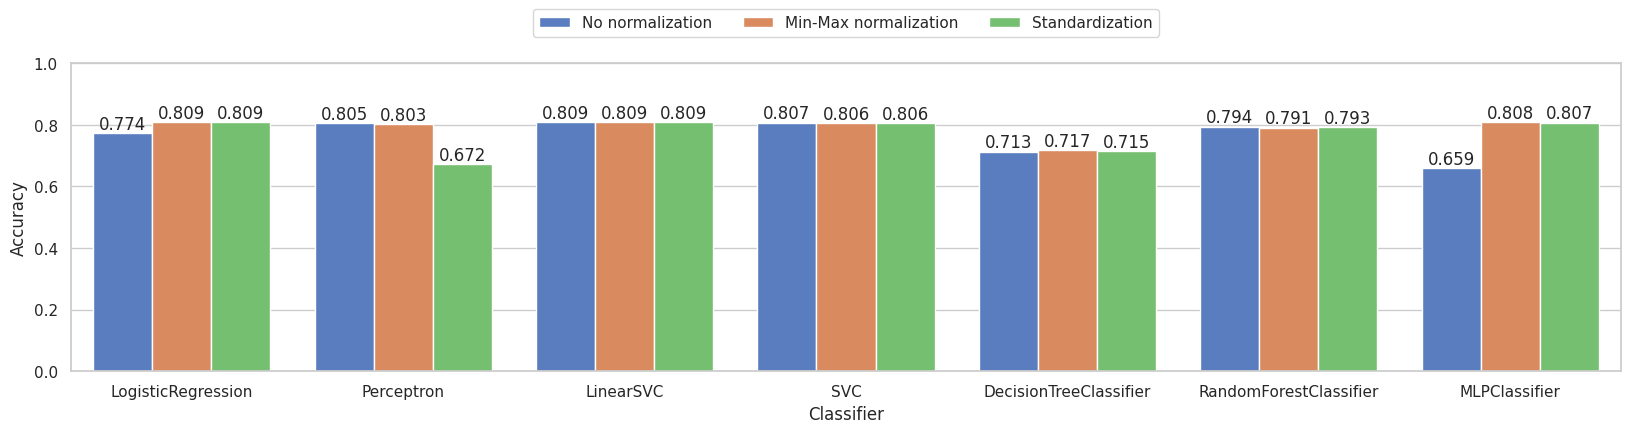

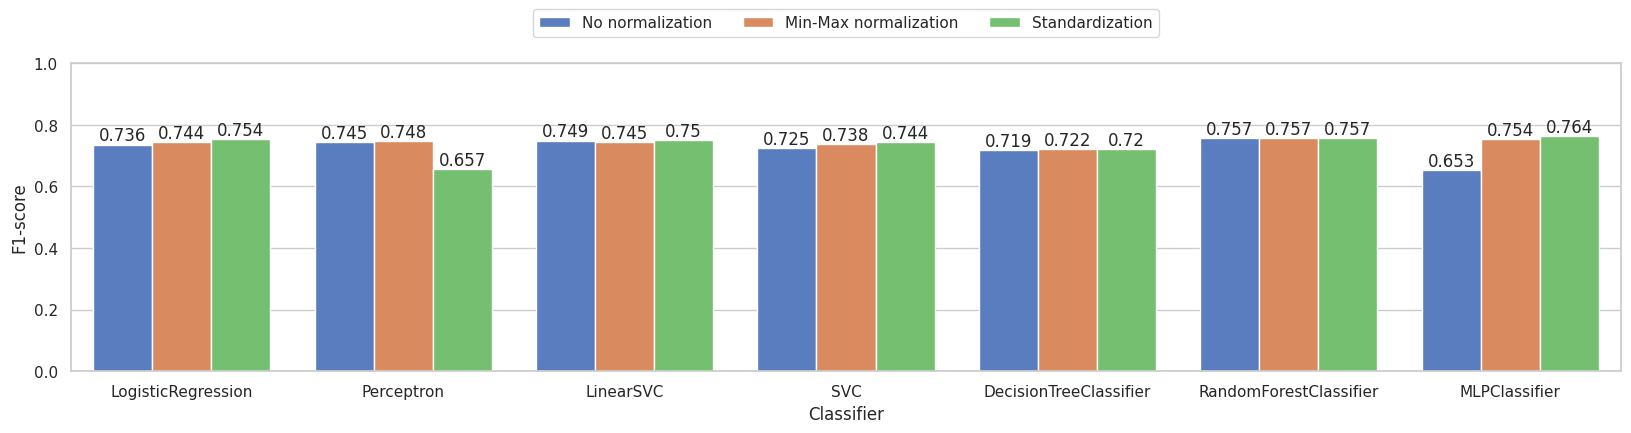

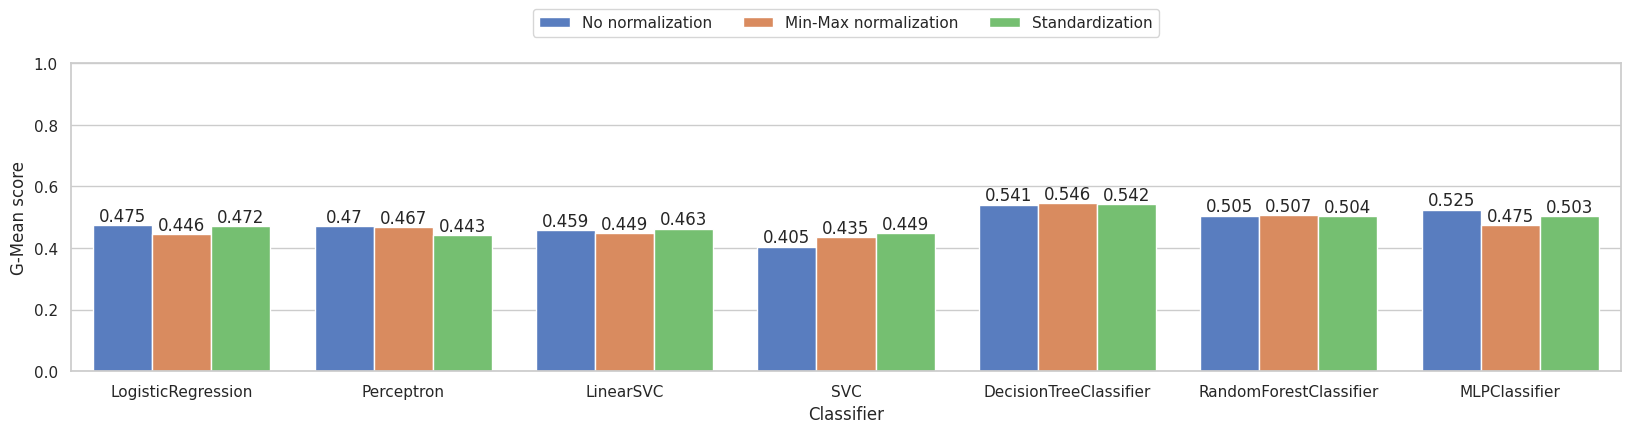

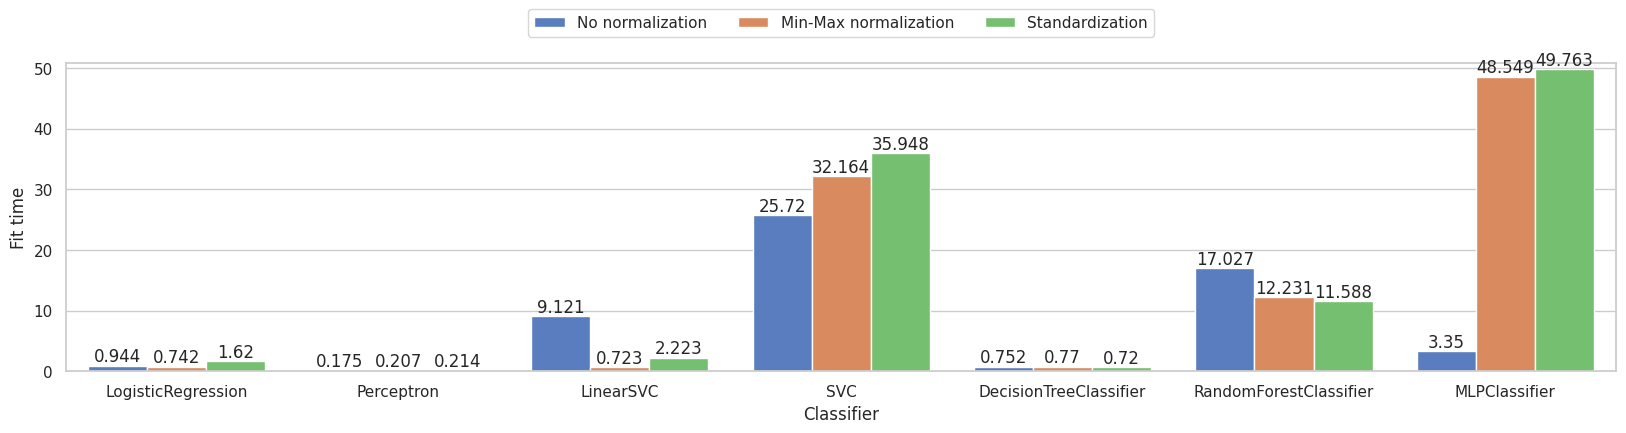

In [64]:
plot_metrics(jm1_results)

### mc1

In [65]:
mc1_results = pd.concat([df_mc1_nn_results, df_mc1_mmn_results, df_mc1_fs_results])
mc1_results = mc1_results.round(3)
mc1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.991,0.989,0.202,2.565,No normalization
1,Perceptron,0.979,0.982,0.083,0.178,No normalization
2,LinearSVC,0.993,0.989,0.084,11.177,No normalization
3,SVC,0.993,0.989,0.084,1.206,No normalization
4,DecisionTreeClassifier,0.994,0.994,0.742,0.287,No normalization
5,RandomForestClassifier,0.995,0.994,0.653,4.679,No normalization
6,MLPClassifier,0.991,0.989,0.164,6.314,No normalization
0,LogisticRegression,0.993,0.989,0.125,0.703,Min-Max normalization
1,Perceptron,0.993,0.990,0.187,0.251,Min-Max normalization
2,LinearSVC,0.993,0.989,0.125,0.584,Min-Max normalization


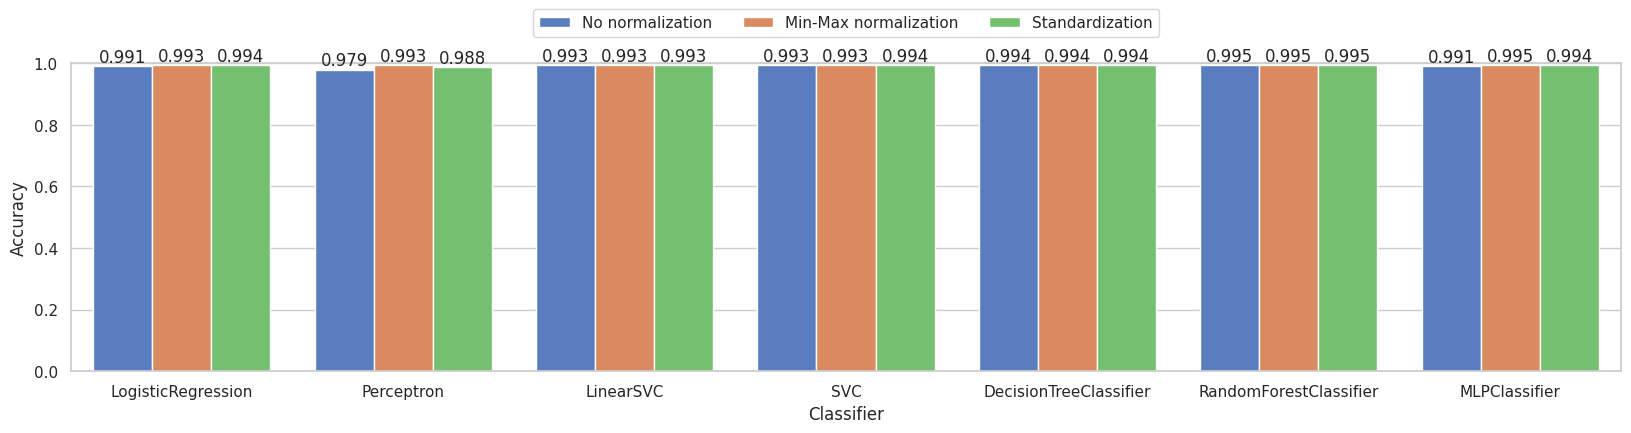

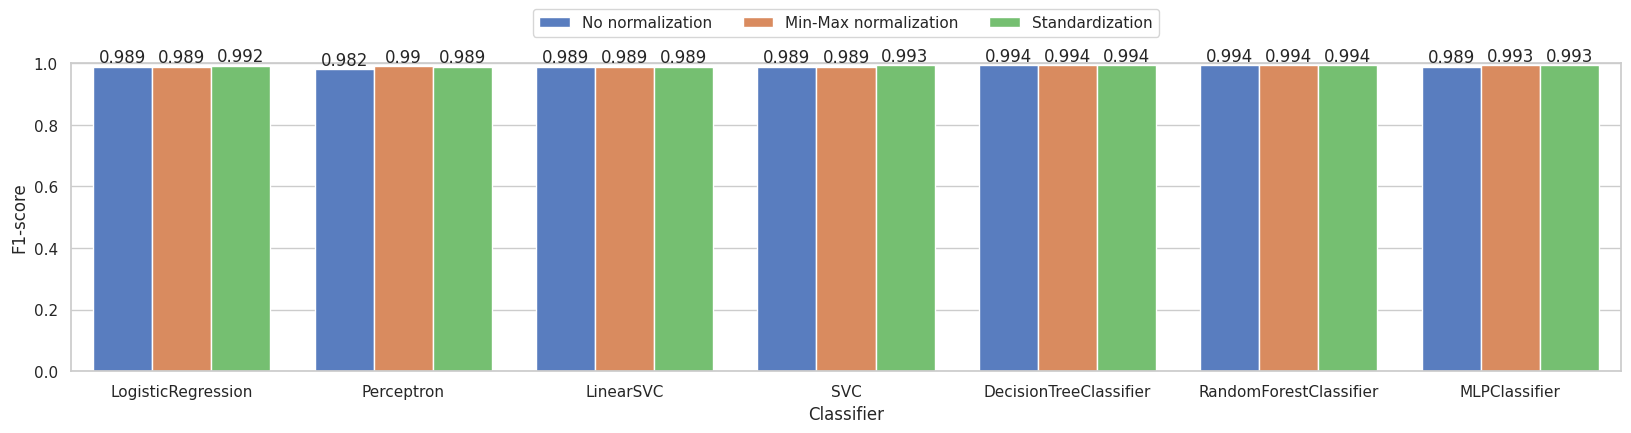

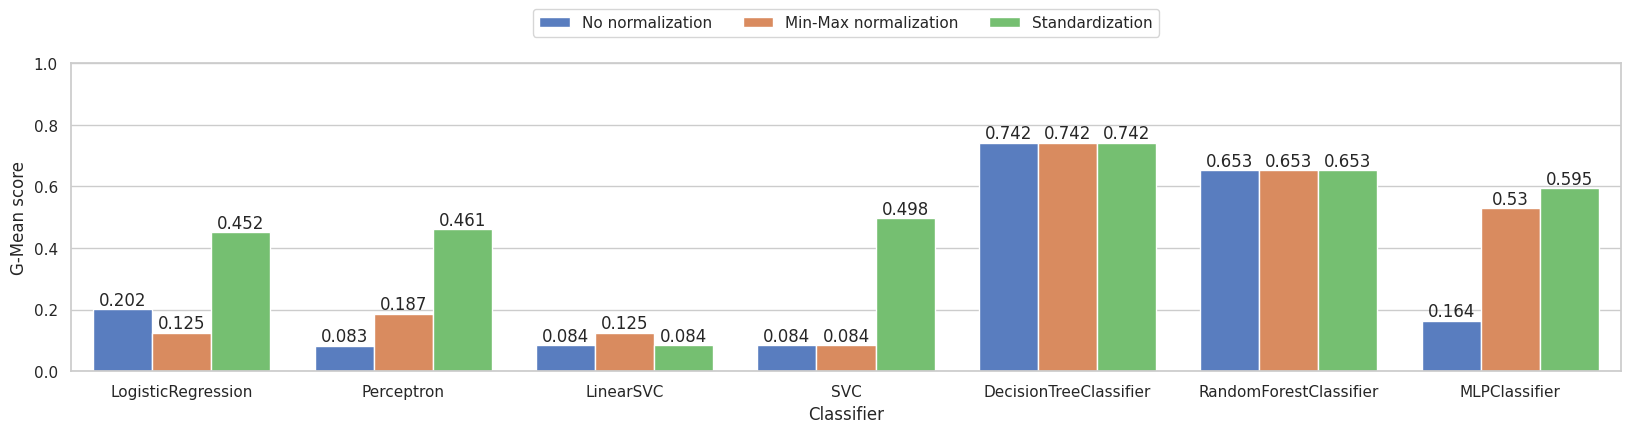

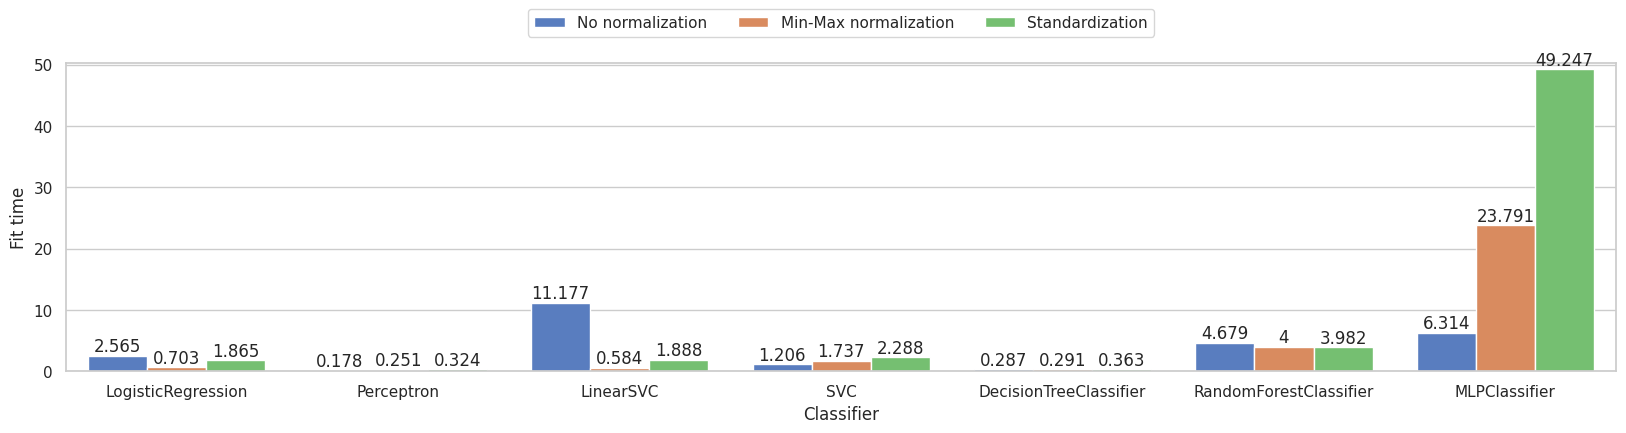

In [66]:
plot_metrics(mc1_results)

### pc3

In [67]:
pc3_results = pd.concat([df_pc3_nn_results, df_pc3_mmn_results, df_pc3_fs_results])
pc3_results = pc3_results.round(3)
pc3_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.900,0.874,0.465,0.221,No normalization
1,Perceptron,0.563,0.606,0.352,0.074,No normalization
2,LinearSVC,0.901,0.875,0.464,0.344,No normalization
3,SVC,0.898,0.849,0.303,0.157,No normalization
4,DecisionTreeClassifier,0.858,0.862,0.604,0.125,No normalization
5,RandomForestClassifier,0.900,0.875,0.465,2.206,No normalization
6,MLPClassifier,0.790,0.811,0.611,1.159,No normalization
0,LogisticRegression,0.898,0.857,0.354,0.140,Min-Max normalization
1,Perceptron,0.820,0.832,0.612,0.072,Min-Max normalization
2,LinearSVC,0.897,0.856,0.346,0.164,Min-Max normalization


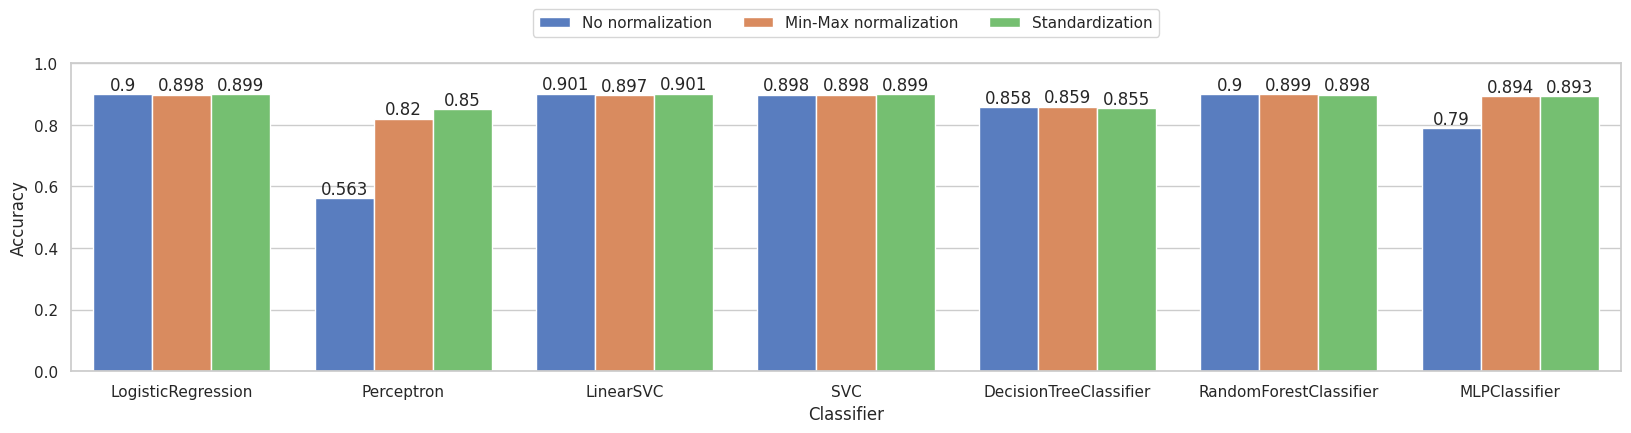

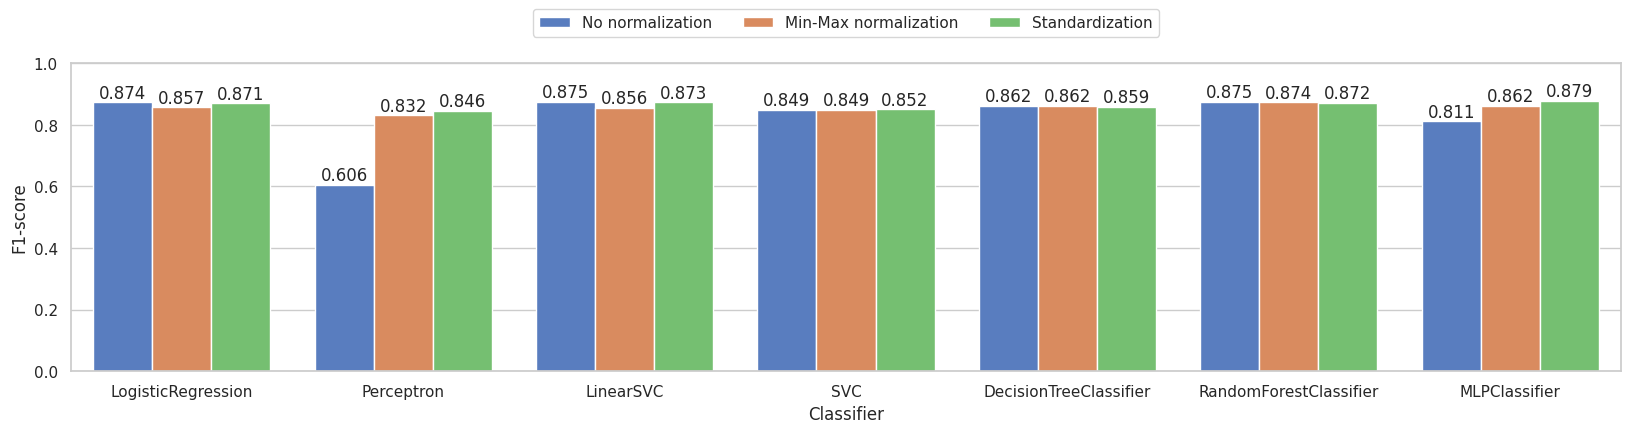

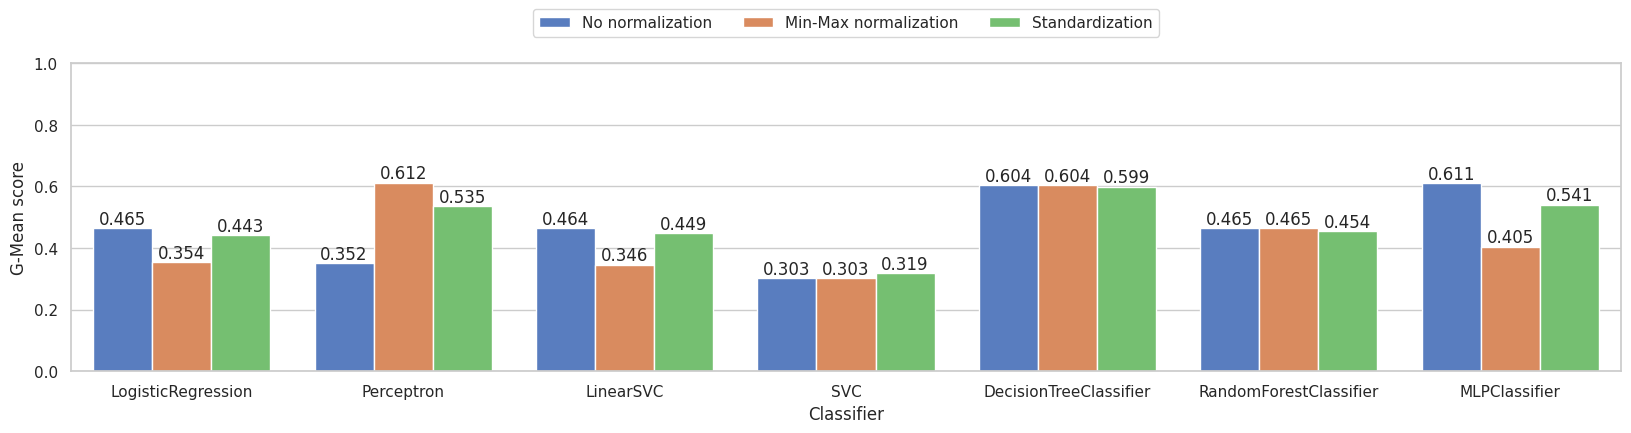

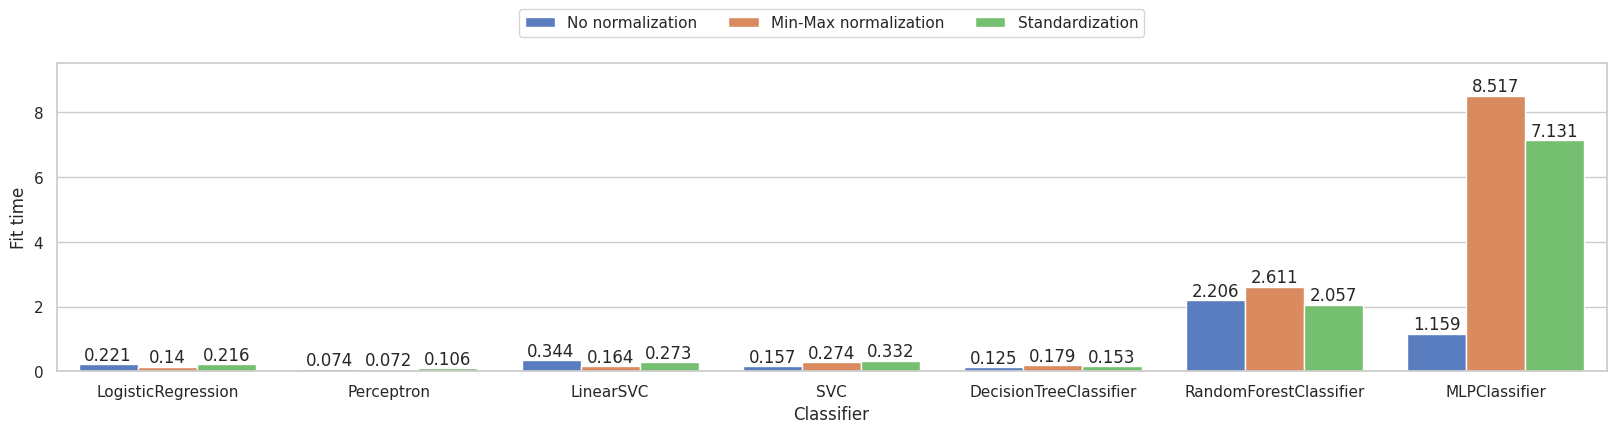

In [68]:
plot_metrics(pc3_results)